# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world. 

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data. 

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- primary color id
- secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- the trained model predicts the four attributes at the same time
- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [1]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

2024-02-12 14:26:36.704194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 14:26:36.704266: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 14:26:36.704322: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 14:26:36.715198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [3]:
PATH = f"/data/2024"

In [4]:
!ls {PATH}

test  train


In [5]:
parquet_filenames_train = !ls {PATH}/train

In [6]:
parquet_filenames_train[:3]

['part-00000-of-00362.parquet',
 'part-00001-of-00362.parquet',
 'part-00002-of-00362.parquet']

In [7]:
f"Number of files in train: {len(parquet_filenames_train):,}"

'Number of files in train: 362'

In [8]:
parquet_filenames_test = !ls {PATH}/test

In [9]:
parquet_filenames_test[:3]

['part-00000-of-00362.parquet',
 'part-00001-of-00362.parquet',
 'part-00002-of-00362.parquet']

In [10]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [11]:
def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [ 
        pd.read_parquet(f"{PATH}/{folder}/{filename}") 
        for filename in filenames
    ]
    
    return pd.concat(dataframes)

In [12]:
df_train = read_data("train", parquet_filenames_train)

In [13]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 229,624'

In [14]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 229,624'

In [15]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 26'

In [16]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [17]:
df_train.iloc[0]

product_id                                                      699437355
title                   Children&#39;s circle skirt BLUE GALAXY made o...
description             The fuxandfriends children&#39;s full circle s...
tags                                                                     
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [18]:
df_train.head(2)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475


In [19]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [20]:
df_train['type'].value_counts(dropna=False)

type
physical    218568
download     10708
               348
Name: count, dtype: int64

In [21]:
COLORS = df_train['primary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of primary colors in train: {NUM_COLORS:,}"

'Number of primary colors in train: 19'

In [22]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [23]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

/tmp/ipykernel_13288/1076920215.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


top_category_text
home_and_living                54600
craft_supplies_and_tools       33393
clothing                       30143
toys_and_games                 13835
accessories                    12416
paper_and_party_supplies       12207
bath_and_beauty                11327
weddings                       10143
shoes                           8892
art_and_collectibles            8716
jewelry                         7822
electronics_and_accessories     7474
bags_and_purses                 6650
books_movies_and_music          6262
pet_supplies                    5744
Name: count, dtype: int64

/tmp/ipykernel_13288/3624248663.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


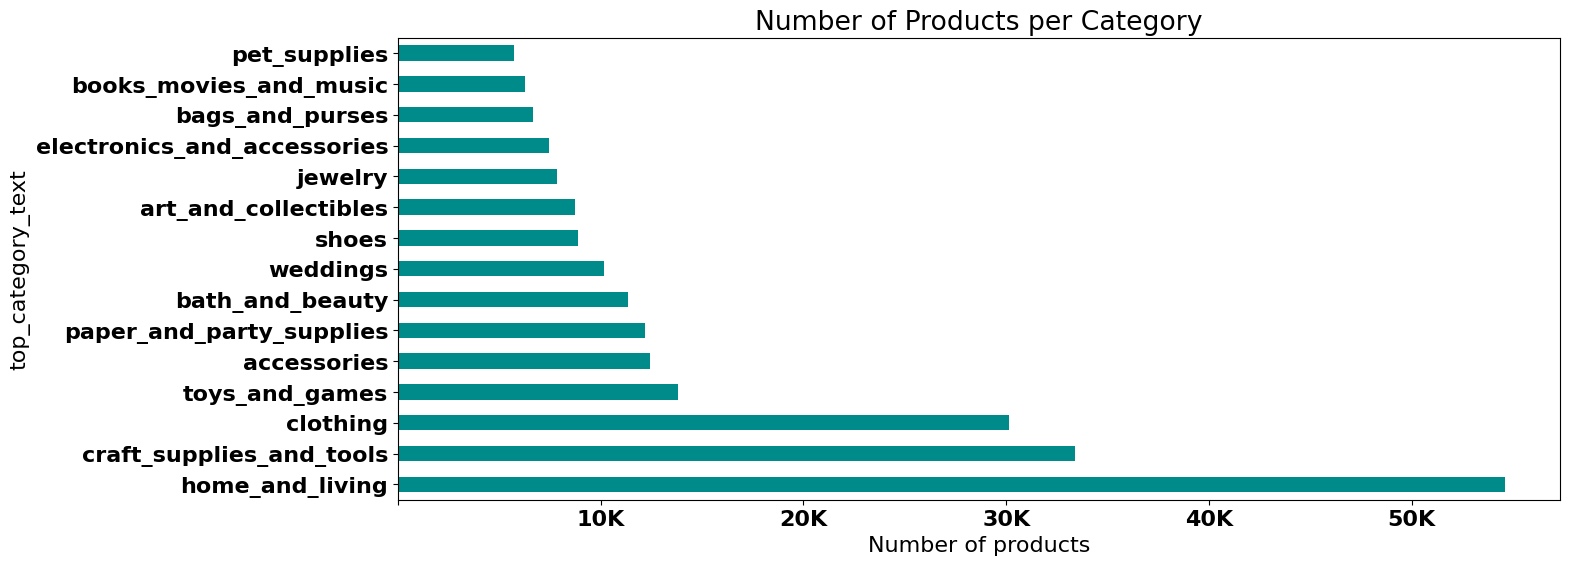

In [24]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'
    
figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column], 
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [25]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,609'

In [26]:
def show_images(dataframe, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row["top_category_text"] if "top_category_text" in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

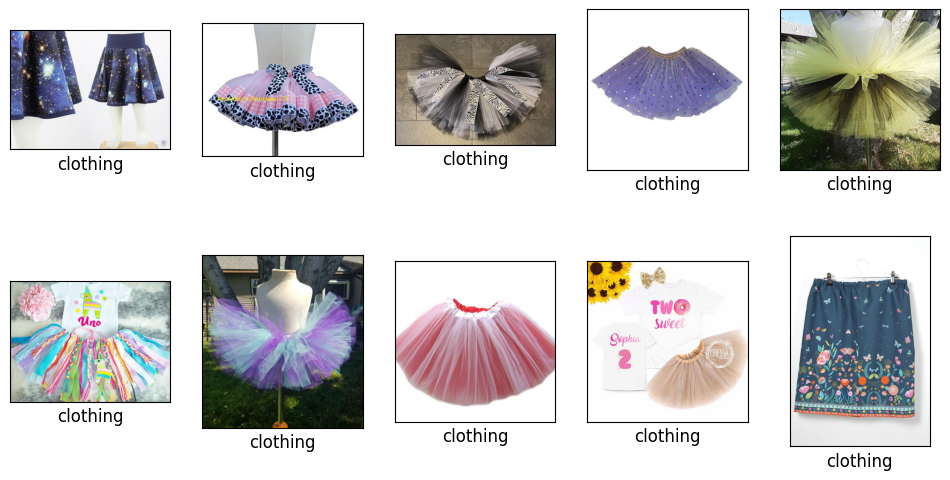

In [27]:
show_images(df_train, 10)

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [28]:
df_test = read_data("test", parquet_filenames_test)

In [29]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [30]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [31]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

In [32]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'image/encoded',
 'image/width',
 'image/height']

In [33]:
df_test.iloc[0]

product_id                                               661373440
title            Classroom Valentine Favors, Valentine Pencils,...
description      Valentine Favors, Robots of Love Vinyl Pencil ...
tags             Valentines day favor,kindergarten treats,valen...
type                                                      physical
room                                                              
craft_type                                            kids' crafts
recipient                                                         
material                                                          
occasion                                                          
holiday                                            valentine's day
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

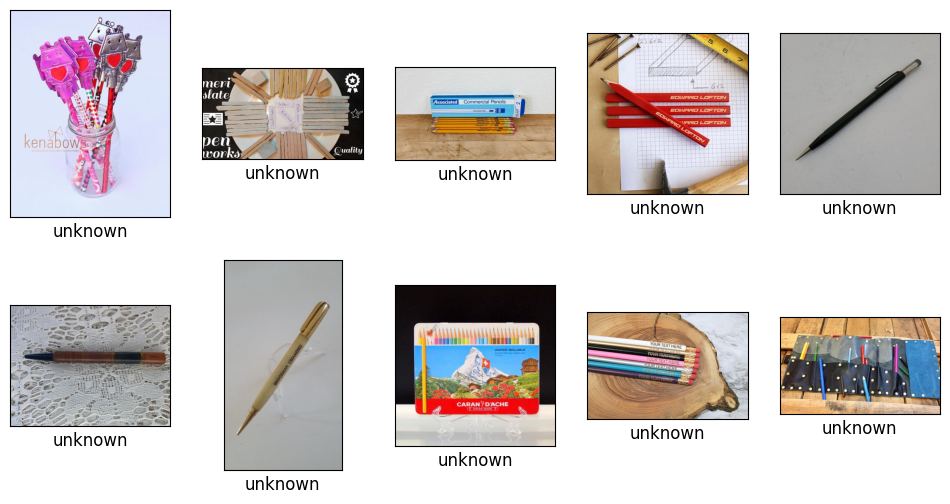

In [34]:
show_images(df_test, 10)

## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [35]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.1, 
    stratify=df_train['bottom_category_text'], 
    random_state=42)

In [36]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [37]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [38]:
df_training['bottom_category_text'].value_counts()

bottom_category_text
jewelry.earrings.dangle_earrings.chandbalis                                         88
accessories.scarves_and_wraps.scarves                                               88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands                   88
craft_supplies_and_tools.closures_and_fasteners.buttons                             88
art_and_collectibles.drawing_and_illustration.architectural_drawings                88
                                                                                    ..
weddings.clothing.jumpsuits_and_rompers                                             40
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                   40
home_and_living.lighting.light_accessories                                          39
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds    38
craft_supplies_and_tools.doll_and_model_supplies.noise_makers                       38
Name: count, Length: 2

In [39]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
clothing.girls_clothing.underwear.panties                                                                             10
craft_supplies_and_tools.paints_inks_and_dyes.paint.chalk_paint                                                       10
clothing.girls_clothing.baby_girls_clothing.sweaters                                                                  10
craft_supplies_and_tools.storage_and_organization.containers.bottles_cans_and_jars.lids_rings_and_caps.bottle_caps    10
paper_and_party_supplies.party_supplies.party_decor.party_candles                                                     10
                                                                                                                      ..
home_and_living.furniture.entryway_furniture.standing_coat_racks                                                       4
jewelry.earrings.kaan_chains                                                                                           4
craft_suppl

In [40]:
df_training['top_category_text'].value_counts()

top_category_text
home_and_living                49140
craft_supplies_and_tools       30056
clothing                       27139
toys_and_games                 12448
accessories                    11173
paper_and_party_supplies       10984
bath_and_beauty                10187
weddings                        9128
shoes                           8001
art_and_collectibles            7846
jewelry                         7040
electronics_and_accessories     6727
bags_and_purses                 5986
books_movies_and_music          5636
pet_supplies                    5170
Name: count, dtype: int64

In [41]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                5460
craft_supplies_and_tools       3337
clothing                       3004
toys_and_games                 1387
accessories                    1243
paper_and_party_supplies       1223
bath_and_beauty                1140
weddings                       1015
shoes                           891
art_and_collectibles            870
jewelry                         782
electronics_and_accessories     747
bags_and_purses                 664
books_movies_and_music          626
pet_supplies                    574
Name: count, dtype: int64

### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [43]:
train_text = df_training['title'].fillna('').values

In [44]:
train_labels = df_training['top_category_text'].values

In [45]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [46]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [47]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Ki...
Prediction: 'home_and_living', Groundtruth: 'home_and_living'


In [48]:
df_validation.iloc[0]

product_id                                                     1085759015
title                   Vintage enamel funnel - White metal funnel wit...
description             Vintage enamel funnel - White metal funnel wit...
tags                    Enamel Funnel,Vintage metal funnel,Enamelware ...
type                                                             physical
room                                                                     
craft_type                                                     winemaking
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [49]:
val_text[:1]

array(['Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Kitchen pouring tool - Bulgarian enamelware - Old shabby chic'],
      dtype=object)

In [50]:
predictions = text_clf.predict(val_text)

In [51]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [52]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6392'

In [53]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.84      0.41      0.55      1243
       art_and_collectibles       0.86      0.09      0.16       870
            bags_and_purses       0.93      0.29      0.45       664
            bath_and_beauty       0.94      0.46      0.62      1140
     books_movies_and_music       0.98      0.31      0.47       626
                   clothing       0.73      0.96      0.83      3004
   craft_supplies_and_tools       0.62      0.77      0.69      3337
electronics_and_accessories       0.96      0.49      0.65       747
            home_and_living       0.54      0.96      0.69      5460
                    jewelry       0.91      0.37      0.53       782
   paper_and_party_supplies       0.80      0.58      0.67      1223
               pet_supplies       0.93      0.28      0.43       574
                      shoes       0.95      0.73      0.83       891
             toys_and_games      

In [54]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 507,    0,    1,    4,    0,  269,  155,    0,  250,    2,    4,
           2,    2,    7,   40],
       [   5,   78,    0,    0,    0,   31,  137,    2,  593,    0,    7,
           1,    0,   12,    4],
       [   2,    0,  195,   11,    0,   44,  114,    1,  279,    0,    5,
           1,    1,    6,    5],
       [  11,    0,    4,  528,    0,   68,  129,    1,  383,    4,    3,
           1,    1,    6,    1],
       [   1,    3,    0,    0,  193,   12,   90,    4,  298,    0,   17,
           3,    0,    4,    1],
       [   7,    0,    0,    2,    1, 2894,   15,    0,   72,    1,    5,
           0,    2,    0,    5],
       [   5,    4,    0,    3,    0,   35, 2576,    1,  676,    2,   21,
           0,    4,    6,    4],
       [   1,    0,    3,    0,    1,   14,   87,  365,  259,    0,    5,
           1,    0,   11,    0],
       [   1,    4,    2,    5,    0,   44,  123,    3, 5235,    0,   27,
           2,    0,   11,    3],
       [  16,    0,    0,    2,    1,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

### Training

As another example, let's train an image classification model to predict color based only on the image as input. We leveraged `MobileNet` as the base model with `imagenet` weights and freezing the layers.

In [55]:
# Sample 5% training dataset for running the notebook in one machine
df_training_sample = df_training.groupby('primary_color_id').sample(frac=0.05) 

In [56]:
f"Number of rows: {len(df_training_sample):,}"

'Number of rows: 10,332'

In [57]:
NUM_CHANNELS = 3
NUM_COLORS = 19

def parse_dataset(features):
    
    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]
    primary_color_id = features["primary_color_id"]
    
    # Image
    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, NUM_CHANNELS],
    )
    image = tf.cast(image, tf.float32)
    
    # Label
    label = tf.cast(tf.one_hot(primary_color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        label
    )

In [58]:
def create_preprocessing_model(target_image_size, should_rescale):
    preprocessing_layers = []
    if should_rescale:
        preprocessing_layers.append(
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
        )
    preprocessing_layers.append(
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    )
    return tf.keras.Sequential(preprocessing_layers)

In [59]:
def transform_image_data(example, preprocessing_model):
    image = tf.expand_dims(example["image"], 0)
    example["image"] = preprocessing_model(image)[0]
    return example

In [60]:
def get_dataset_batch(
    dataframe,
    batch_size: int,
    mode: tf.estimator.ModeKeys,
) -> tf.data.Dataset:
    
    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN

    # Adding all values in memory will not work for the whole dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image": tf.convert_to_tensor(dataframe["image/encoded"].values, dtype=tf.string),
                "height": tf.convert_to_tensor(dataframe["image/height"].values, dtype=tf.int32),
                "width": tf.convert_to_tensor(dataframe["image/width"].values, dtype=tf.int32),
                "primary_color_id": tf.convert_to_tensor(dataframe["primary_color_id"].values, dtype=tf.int32),
            }
        )
    )
    dataset = dataset.map(
        lambda x: parse_dataset(x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    preprocessing_model = create_preprocessing_model(
        target_image_size=224,
        should_rescale=True,
    )
    dataset = dataset.map(
        lambda x, y: (transform_image_data(x, preprocessing_model), y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [61]:
BATCH_SIZE = 16

In [62]:
train_dataset = get_dataset_batch(
    dataframe=df_training_sample,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

2024-02-12 14:28:02.024496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:28:02.030905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:28:02.138516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [63]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
)

In [64]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [65]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [66]:
with strategy.scope():
    
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_COLORS, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [67]:
for layer in base_model.layers:
    layer.trainable = False

In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['image[0][0]']               
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [69]:
epochs = 10

hist = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 142 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 142 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-02-12 14:28:55.836993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-12 14:28:55.960355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-12 14:29:02.665256: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef3fac9aa80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 14:29:02.665355: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-12 14:29:02.665369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-02-12 14:29:02.694220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 14:29:02.897323: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!

645/645 [==============================] - 128s 102ms/step - loss: 2.1629 - accuracy: 0.6357 - val_loss: 9088.5488 - val_accuracy: 0.0909
Epoch 2/10
645/645 [==============================] - 62s 96ms/step - loss: 5.8938 - accuracy: 0.6586 - val_loss: 2.7948 - val_accuracy: 0.1205
Epoch 3/10
645/645 [==============================] - 62s 96ms/step - loss: 1.3813 - accuracy: 0.6915 - val_loss: 1079.1200 - val_accuracy: 0.1212
Epoch 4/10
645/645 [==============================] - 62s 97ms/step - loss: 1.6888 - accuracy: 0.6446 - val_loss: 6095.3735 - val_accuracy: 0.1212
Epoch 5/10
645/645 [==============================] - 63s 97ms/step - loss: 2.6767 - accuracy: 0.6808 - val_loss: 3.1608 - val_accuracy: 0.0500
Epoch 6/10
645/645 [==============================] - 62s 96ms/step - loss: 1.3834 - accuracy: 0.6478 - val_loss: 3.3098 - val_accuracy: 0.0718
Epoch 7/10
645/645 [==============================] - 62s 96ms/step - loss: 1.1660 - accuracy: 0.6985 - val_loss: 254.4213 - val_accurac

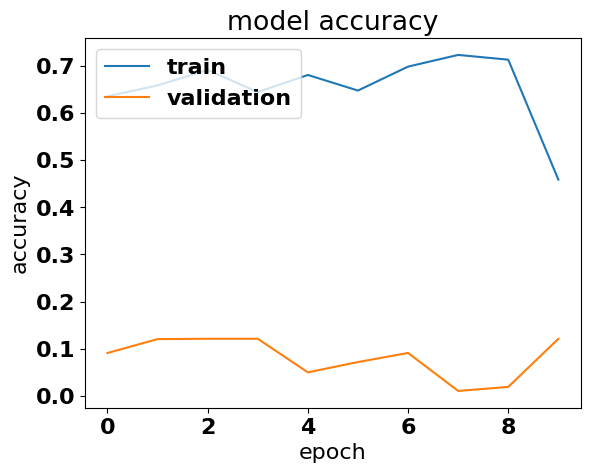

In [70]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [71]:
model.evaluate(val_dataset, batch_size=BATCH_SIZE, verbose=1)

1435/1435 [==============================] - 31s 22ms/step - loss: 138.4445 - accuracy: 0.1212


[138.44451904296875, 0.12116724997758865]

In [72]:
predictions = model.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)

1435/1435 [==============================] - 33s 21ms/step


In [73]:
predictions

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**Note** again that is just another baseline that only uses the `image` as the input and generates predictions after freezing all the layers for that base model.

Go wild and try different architectures and approaches, use several modalities, apply augmentations on the preprocessing layers, predict several targets at the same time, etc!

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [74]:
df_predictions = df_test.copy()

In [75]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["secondary_color_id"] = np.zeros(len(df_test), dtype=int)

In [76]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]
].to_parquet(f"predictions_{student_id}.parquet")